In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/src/

/content/drive/MyDrive/src


In [3]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

from modules import MLPAutoEncoder, GatingNN, ClusteringNN
from losses import SparseLoss, ClusterLoss
from utils import random_binary_mask, cosine_scheduler

In [ ]:
def clustering_accuracy(labels_true, labels_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics.cluster import _supervised

    labels_true, labels_pred = _supervised.check_clusterings(labels_true, labels_pred)
    value = _supervised.contingency_matrix(labels_true, labels_pred)
    [r, c] = linear_sum_assignment(-value)
    return value[r, c].sum() / len(labels_true)

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [10]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_X = mnist_trainset.data.reshape(-1, 784) / 255.
mnist_y = mnist_trainset.targets

In [11]:
mnist_X.size(), mnist_y.size()

(torch.Size([60000, 784]), torch.Size([60000]))

In [12]:
from sklearn.model_selection import train_test_split

idx = list(range(len(mnist_X)))
idx_train, idx_val = train_test_split(list(range(len(idx))), test_size=0.9, stratify=mnist_y)

In [13]:
mnist_X = mnist_X[idx_train] / 255.
mnist_y = mnist_y[idx_train]

In [14]:
mnist_X.size(), mnist_y.size()

(torch.Size([6000, 784]), torch.Size([6000]))

In [15]:
mnist_dataset = TensorDataset(mnist_X, mnist_y)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


AE Training finished!


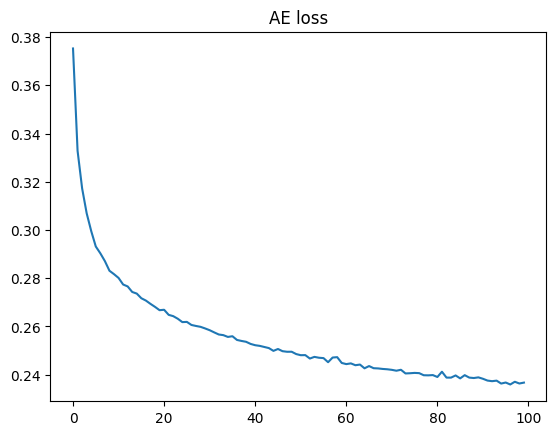

In [ ]:
mnist_layer_dims = [784, 512, 512, 2048, 10]

BATCH_SIZE = 256
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

ae = MLPAutoEncoder(mnist_layer_dims)
criterion = SparseLoss(pretrain=True)

ae = ae.to(device)

LR = 1e-3
EPOCHS = 100

optimizer = optim.Adam(ae.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0

    for x, y in mnist_dataloader:

        x = x.to(device)

        x_hat = ae(x)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat, local_gates_lmbd=10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(mnist_dataloader)
    losses.append(avg_epoch_loss)

print('AE Training finished!')
plt.plot(losses)
plt.title("AE loss")
plt.show()

100%|██████████| 100/100 [05:31<00:00,  3.32s/it]


ALL Training finished!


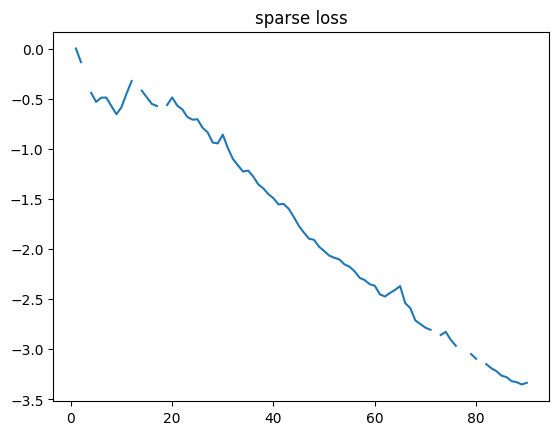

In [ ]:
gnn = GatingNN(784, 784)
gnn = gnn.to(device)

LR = 1e-3
EPOCHS = 100

optimizer = optim.Adam(list(gnn.parameters()) + list(ae.parameters()), lr=LR)
criterion = SparseLoss(pretrain=False)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for x, y in mnist_dataloader:

        x = x.to(device)

        x_z, z, u = gnn(x)
        x_hat = ae(x)
        x_z_hat = ae(x_z)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat, x_z_hat, z, u, lmbd, local_gates_lmbd=10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(mnist_dataloader)
    losses.append(avg_epoch_loss)

print('ALL Training finished!')
plt.plot(losses)
plt.title("sparse loss")
plt.show()

In [ ]:
with torch.no_grad():
    X = mnist_X.to(device)
    X_Z ,z , _ = gnn(X)
    X_z_hat = ae(X_Z)
    X_hat = ae(X)

    plt.imshow(X_Z[0].reshape(28, 28).cpu().detach().numpy())
    plt.show()

    plt.imshow(X[0].reshape(28, 28).cpu().detach().numpy())
    plt.show()

In [ ]:
X = mnist_X.to(device)
X_Z ,z , _ = gnn(X)

# # encode from X
# H_from_X = ae.encoder(X)

# encode from X_Z
H_from_X_Z = ae.encoder(X_Z)

In [ ]:
cluster_dataset = TensorDataset(X_Z, H_from_X_Z, mnist_y)

BATCH_SIZE = 256
cluster_dataloader = DataLoader(cluster_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


ClusterHead Training finished!


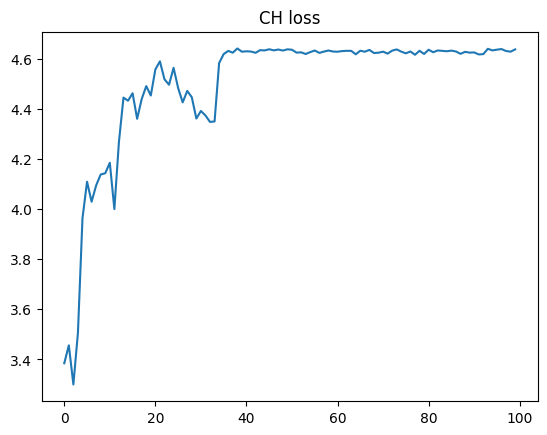

In [ ]:
clust = ClusteringNN(784, 10, 2048, 10, tau=5)
criterion = ClusterLoss(10, pretrain=True)

clust = clust.to(device)

LR = 1e-2
EPOCHS = 100

optimizer = optim.Adam(clust.cluster_head.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for i, (x, h, y) in enumerate(cluster_dataloader):

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss = criterion(h, clust_logits, aux_logits, u_zg, lmbd, gamma=4)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(cluster_dataloader)
    losses.append(avg_epoch_loss)

print('ClusterHead Training finished!')
plt.plot(losses)
plt.title("CH loss")
plt.show()

In [ ]:
with torch.no_grad():
    X = mnist_X.to(device)
    X_Z ,z , _ = gnn(X)
    H = ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = clust(X_Z, H)
    yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(yhat, mnist_y))

tensor(0.0867)

In [17]:
criterion = ClusterLoss(10, pretrain=False)

LR_AUX = 1e-2
LR_ZG = 1e-1

EPOCHS = 100

optimizer_aux = optim.SGD(clust.aux_classifier.parameters(), lr=LR_AUX)
optimizer_ZG = optim.SGD(clust.global_gates.parameters(), lr=LR_ZG)

losses_head = []
losses_aux = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss_head = 0.0
    epoch_loss_aux = 0.0

    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for i, (x, h, y) in enumerate(cluster_dataloader):

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss_head, loss_aux = criterion(h, clust_logits, aux_logits, u_zg, lmbd, gamma=4)

        optimizer.zero_grad()
        loss_head.backward(retain_graph=True)
        optimizer.step()

        optimizer_aux.zero_grad()
        optimizer_ZG.zero_grad()
        loss_aux.backward(retain_graph=True)
        optimizer_aux.step()
        optimizer_ZG.step()

        epoch_loss_head += loss_head.item()
        epoch_loss_aux += loss_aux.item()

    # Save the average loss for the epoch
    avg_epoch_loss_head = epoch_loss_head / len(cluster_dataloader)
    losses_head.append(avg_epoch_loss_head)

    avg_epoch_loss_aux = epoch_loss_aux / len(cluster_dataloader)
    losses_aux.append(avg_epoch_loss_aux)

print('ClusterHead Training finished!')

plt.plot(losses_head)
plt.title("Head loss")
plt.show()

plt.plot(losses_aux)
plt.title("Aux loss")
plt.show()

In [ ]:
with torch.no_grad():
    X = mnist_X.to(device)
    X_Z ,z , _ = gnn(X)
    H = ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = clust(X_Z, H)
    yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(yhat, mnist_y))